# Benchmarking of various implementations of FADDEEVA's error functions

Please compile the shared libraries by running the `Makefile`:

In [1]:
!make

## I. Setup

Import the multiprecision library `mpmath` as a reference for accuracy benchmarks:

In [2]:
import mpmath

Import the rest of the usual lot:

In [30]:
import numpy as np
import scipy
import sys
import time
from collections import OrderedDict
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [4]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm
%matplotlib inline

sns.set_style("white")
cmap = matplotlib.colors.ListedColormap(sns.color_palette("Blues", 256))
cmap2 = matplotlib.colors.ListedColormap(sns.cubehelix_palette(8, 256))
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'

Timer class for a more convenient timing:

In [5]:
class Timer(object):
    '''Uses time.time() as timer.clock() doesn't work with GPU...'''
    def __enter__(self):
        self.start = time.time()
        return self

    def __exit__(self, *args):
        self.end = time.time()
        self.interval_s = self.end - self.start

The dictionary `wofz_impl` accesses the various function implementations.

Input interface is `wofz_impl[<implementation language>](x, y)`: 
`x` is the real and `y` is the imaginary part of the input, both should be numpy arrays (i.e. provide the ctypes field).

In [31]:
wofz_impl = OrderedDict()

### mpmath (reference)

set the precision:

In [7]:
mpmath.mp.dps = 50

prepare the `wofz_impl` entry:

In [32]:
def wofz(x, y):
    z = mpmath.mpc(x, y)
    w = mpmath.exp(-z**2) * mpmath.erfc(z * -1j)
    return w.real, w.imag
wofz_impl['mp'] = np.vectorize(wofz)

### scipy (version > 0.14)

http://ab-initio.mit.edu/wiki/index.php/Faddeeva_Package

In [9]:
from scipy.special import wofz as scipy_wofz

prepare the `wofz_impl` entry:

In [33]:
def wofz(x, y):
    z = scipy_wofz(x + 1j*y)
    return z.real, z.imag
wofz_impl['scipy'] = wofz

### cernlib_c


embedding the file in cython:

(N.B.: our implementation here relies on 2D numpy.ndarray inputs)

In [11]:
%%cython --name cernlib_c
# distutils: sources = ./cernlib_c/ErrorFunctions.c

import numpy as np
cimport numpy as np

cdef extern void cerrf(double in_real, double in_imag, double* out_real, double* out_imag)

cpdef tuple wofz(np.ndarray[double, ndim=2, mode="c"] in_real,
                 np.ndarray[double, ndim=2, mode="c"] in_imag):
    cdef np.ndarray[double, ndim=2, mode="c"] out_real = \
        np.empty_like(in_real)
    cdef np.ndarray[double, ndim=2, mode="c"] out_imag = \
        np.empty_like(in_real)
    cdef int i = 0
    cdef int j = 0
    cdef int m = in_real.shape[0]
    cdef int n = in_real.shape[1]
    for i in xrange(m):
        for j in xrange(n):
            cerrf(in_real[i, j], in_imag[i, j], &out_real[i, j], &out_imag[i, j])
    return (out_real, out_imag)

prepare the `wofz_impl` entry:

In [34]:
import cernlib_c
wofz_impl['c'] = cernlib_c.wofz

### cernlib_cuda

try whether PyCUDA is available for the CUDA FADDEEVA version:

In [13]:
i_pycuda = False
try:
    from pycuda.autoinit import context
    from pycuda import gpuarray
    from pycuda.elementwise import ElementwiseKernel
    i_pycuda = True
except ImportError as e:
    print 'No PyCUDA available, as per error message:'
    print e.message

prepare the CUDA kernel for the wofz function:

In [14]:
if i_pycuda:
    kernel = ElementwiseKernel(
        'double* in_real, double* in_imag, double* out_real, double* out_imag',
#         'out_real[i] = in_real[i]; out_imag[i] = in_imag[i]',
        'wofz(in_real[i], in_imag[i], &out_real[i], &out_imag[i]);',
        'wofz_kernel',
        preamble=open('cernlib_cuda/wofz.cu', 'r').read()
    )

prepare the `wofz_impl` entry:

(N.B.: the function call will include the transfers to and from the GPU!)

In [35]:
if i_pycuda:
    def wofz(x, y):
        in_real = gpuarray.to_gpu(np.atleast_1d(x).astype(np.float64))
        in_imag = gpuarray.to_gpu(np.atleast_1d(y).astype(np.float64))
        out_real = gpuarray.empty(in_real.shape, dtype=np.float64)
        out_imag = gpuarray.empty(in_imag.shape, dtype=np.float64)
        kernel(in_real, in_imag, out_real, out_imag)
        return out_real.get(), out_imag.get()
    wofz_impl['cuda'] = wofz

### cernlib_f90_1

import and numpy-vectorise the first f90 version:

(N.B.: You need to have called the `Makefile` beforehand in order to have the compiled shared fortran libraries available!)

In [36]:
sys.path.append('cernlib_f90_1')
from wwerf import ccperrfr

wofz_impl['f90-1'] = np.vectorize(ccperrfr)

### cernlib_f90_2

import and numpy-vectorise the second f90 version:

In [37]:
sys.path.append('cernlib_f90_2')
from wwerf2 import errf

wofz_impl['f90-2'] = np.vectorize(errf)

### cernlib_root_adapted

In [38]:
%%cython --name cernlib_root_adapted
# distutils: include_dirs = ./cernlib_root_adapted/erfc.h
# distutils: sources = ./cernlib_root_adapted/wofz.c ./cernlib_root_adapted/erfc.c
# distutils: extra_compile_args = -std=c99 -W -Wall -Wextra -pedantic -O3 -ftree-vectorize

import numpy as np
cimport numpy as np

cdef extern void wofz(double in_re, double in_im, double* out_re, double* out_im)
cdef extern void wofz_2(double in_re, double in_im, double* out_re, double* out_im)
#cdef extern void wofzf(double in_re, double in_im, double* out_re, double* out_im)

cpdef tuple wofz_def(np.ndarray[double, ndim=2, mode="c"] in_real,
                  np.ndarray[double, ndim=2, mode="c"] in_imag):
    cdef np.ndarray[double, ndim=2, mode="c"] out_real = \
        np.empty_like(in_real)
    cdef np.ndarray[double, ndim=2, mode="c"] out_imag = \
        np.empty_like(in_real)
    cdef int i = 0
    cdef int j = 0
    cdef int m = in_real.shape[0]
    cdef int n = in_real.shape[1]
    for i in xrange(m):
        for j in xrange(n):
            wofz(in_real[i, j], in_imag[i, j], &out_real[i, j], &out_imag[i, j])
    return (out_real, out_imag)

cpdef tuple wofz_euler(np.ndarray[double, ndim=2, mode="c"] in_real,
                  np.ndarray[double, ndim=2, mode="c"] in_imag):
    cdef np.ndarray[double, ndim=2, mode="c"] out_real = \
        np.empty_like(in_real)
    cdef np.ndarray[double, ndim=2, mode="c"] out_imag = \
        np.empty_like(in_real)
    cdef int i = 0
    cdef int j = 0
    cdef int m = in_real.shape[0]
    cdef int n = in_real.shape[1]
    for i in xrange(m):
        for j in xrange(n):
            wofz_2(in_real[i, j], in_imag[i, j], &out_real[i, j], &out_imag[i, j])
    return (out_real, out_imag)

Using the complex exponential function in C to compute 

$$\exp(-z^2) \times \text{erfc}(-iz)$$

In [39]:
from cernlib_root_adapted import wofz_def

wofz_impl['c-root-adapt'] = wofz_def

Using the Euler formula to avoid the complex error function,

$$\exp(-(a+ib)^2) = \exp(-a^2+b^2) \bigl( \cos(2 a b) - i \sin(2 a b) \bigr)$$

In [40]:
from cernlib_root_adapted import wofz_euler

wofz_impl['c-root-adapt_2'] = wofz_euler

### cernlib-root-adapted -DFAST_IMPL

In [22]:
%%cython --name cernlib_root_adapted_dfastimpl
# distutils: include_dirs = ./cernlib_root_adapted/erfc.h
# distutils: sources = ./cernlib_root_adapted/wofz.c ./cernlib_root_adapted/erfc.c
# distutils: extra_compile_args = -std=c99 -W -Wall -Wextra -pedantic -O3 -ftree-vectorize -DFAST_IMPL

import numpy as np
cimport numpy as np

cdef extern void wofz(double in_re, double in_im, double* out_re, double* out_im)

cpdef tuple wofz_def(np.ndarray[double, ndim=2, mode="c"] in_real,
                  np.ndarray[double, ndim=2, mode="c"] in_imag):
    cdef np.ndarray[double, ndim=2, mode="c"] out_real = \
        np.empty_like(in_real)
    cdef np.ndarray[double, ndim=2, mode="c"] out_imag = \
        np.empty_like(in_real)
    cdef int i = 0
    cdef int j = 0
    cdef int m = in_real.shape[0]
    cdef int n = in_real.shape[1]
    for i in xrange(m):
        for j in xrange(n):
            wofz(in_real[i, j], in_imag[i, j], &out_real[i, j], &out_imag[i, j])
    return (out_real, out_imag)

In [41]:
from cernlib_root_adapted_dfastimpl import wofz_def

wofz_impl['c-root-adapt-fast'] = wofz_def

### cernlib-root-adapted -DSINCOS

In [24]:
%%cython --name cernlib_root_adapted_dsincos
# distutils: include_dirs = ./cernlib_root_adapted/erfc.h
# distutils: sources = ./cernlib_root_adapted/wofz.c ./cernlib_root_adapted/erfc.c
# distutils: extra_compile_args = -std=c99 -W -Wall -Wextra -pedantic -O3 -ftree-vectorize -DSINCOS

import numpy as np
cimport numpy as np

cdef extern void wofz(double in_re, double in_im, double* out_re, double* out_im)

cpdef tuple wofz_def(np.ndarray[double, ndim=2, mode="c"] in_real,
                  np.ndarray[double, ndim=2, mode="c"] in_imag):
    cdef np.ndarray[double, ndim=2, mode="c"] out_real = \
        np.empty_like(in_real)
    cdef np.ndarray[double, ndim=2, mode="c"] out_imag = \
        np.empty_like(in_real)
    cdef int i = 0
    cdef int j = 0
    cdef int m = in_real.shape[0]
    cdef int n = in_real.shape[1]
    for i in xrange(m):
        for j in xrange(n):
            wofz(in_real[i, j], in_imag[i, j], &out_real[i, j], &out_imag[i, j])
    return (out_real, out_imag)

In [42]:
from cernlib_root_adapted_dsincos import wofz_def

wofz_impl['c-root-adapt-sincos'] = wofz_def

## II. Accuracy Benchmark

### Accuracy within range $10^{-8}$ to $10^8$

(outside of this, the `mpmath` multiplications of extremely large and small factors do not behave well)

define range:

In [52]:
exp_min = -8
exp_max = 8

r = 10**np.linspace(exp_min, exp_max, 101)
x, y = np.meshgrid(r, r)

the reference values via `mpmath`:

In [27]:
wr_ref, wi_ref = wofz_impl['mp'](x, y)

/home/oeftiger/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family [u'cursive'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


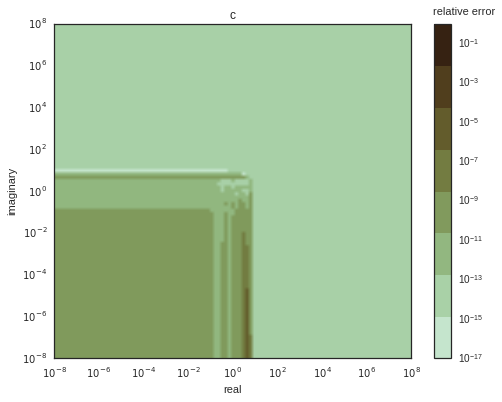

In [28]:
def plot_error(x,y,z, title, unify=True):
    fig, ax = plt.subplots(figsize=(8,6))
    if unify:
        z = np.clip(a=z, a_min=1e-17, a_max=1e0)
        im  = ax.imshow(
                   #np.vectorize(mpmath.log10)(z).astype(np.float64),
                   z.astype(np.float64),
                   origin="bottom",extent=[exp_min,exp_max,exp_min,exp_max],aspect='auto',
                   vmin=1e-17, vmax=1e0, norm=LogNorm(),
                   cmap=cmap2)
    else:
        im = ax.imshow(np.vectorize(mpmath.log10)(z).astype(np.float64),
                       origin="bottom",extent=[exp_min,exp_max,exp_min,exp_max],aspect='auto',
                       cmap=cmap2)

    # Plot look: axes, title, ticks, ...
    cbar = plt.colorbar(im)
    cbar.set_label('relative error', labelpad=-18, y=1.05, rotation=0)
    ax.set_title(title)
    ax.set_xlabel('real')
    ax.set_ylabel('imaginary')
    ax.set_xticklabels([ "$10^{" + str(i) + "}$" for i in range(exp_min, exp_max + 1, 2)])
    ax.set_yticklabels([ "$10^{" + str(i) + "}$" for i in range(exp_min, exp_max + 1, 2)])
    
    return fig, ax

test = True
if test is True:
    wr, wi = wofz_impl['c'](x, y)
    z = abs(wr - wr_ref)/wr_ref
    #z = abs(wi - wi_ref)/wi_ref
    fig, ax = plot_error(x,y,z, title='c',unify=True)

### Compare the relative errors for the different implementations
You can either plot the real or the imaginar parts by setting z to real_error or imag_error

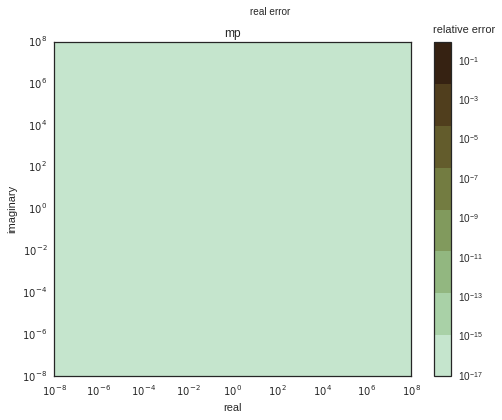

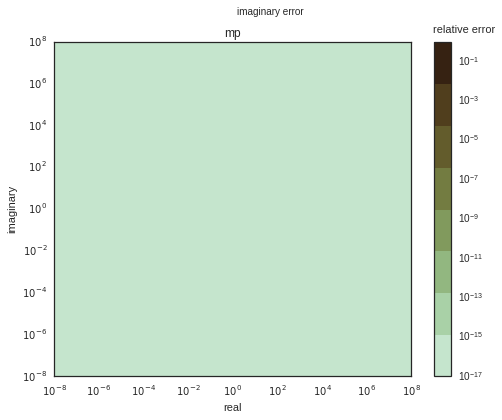

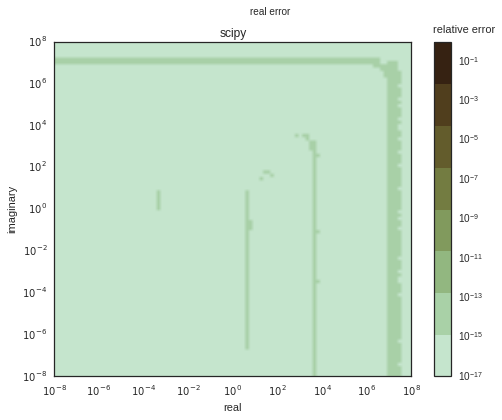

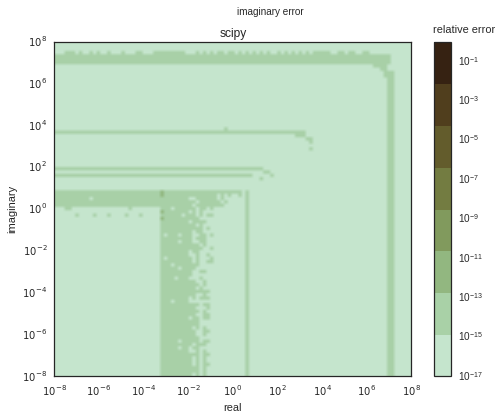

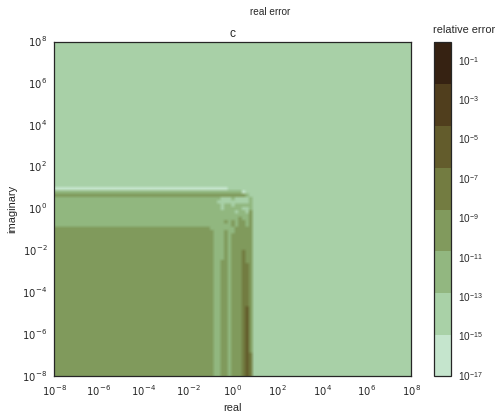

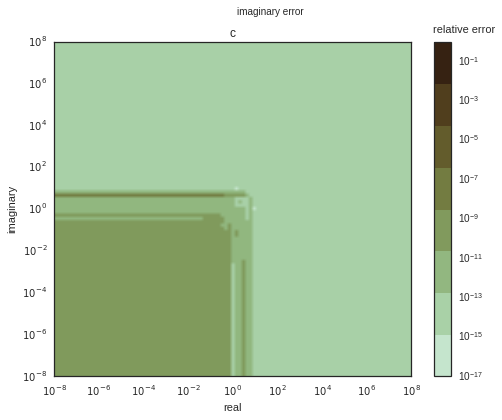

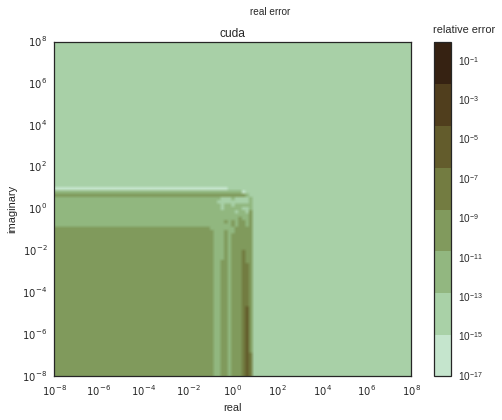

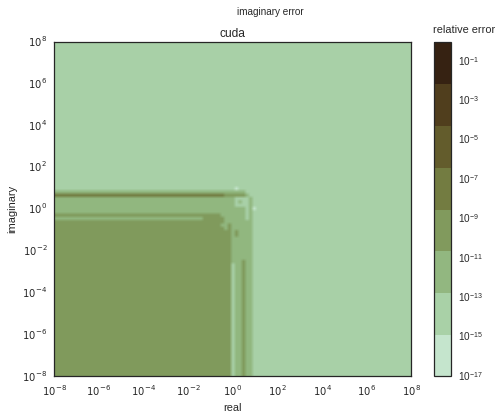

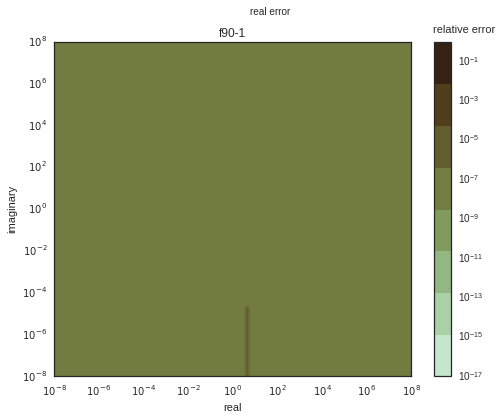

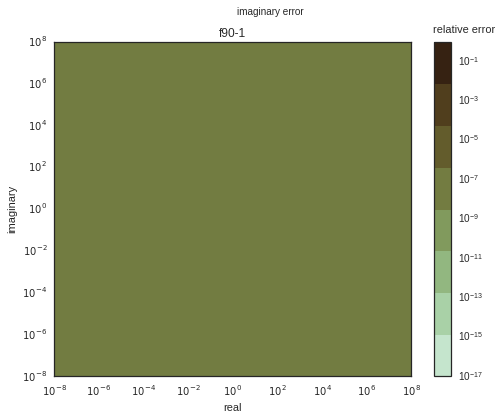

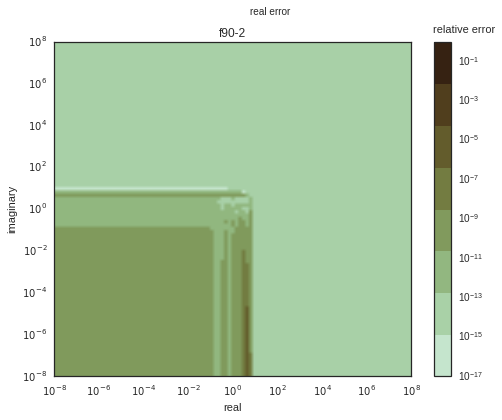

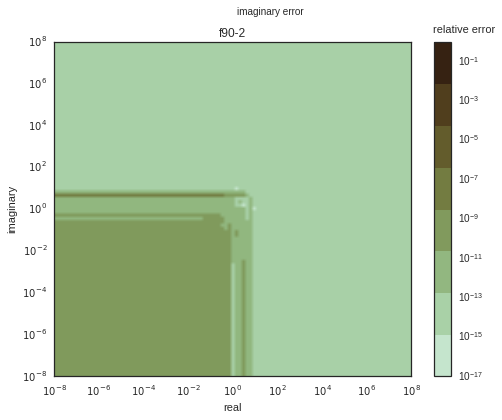

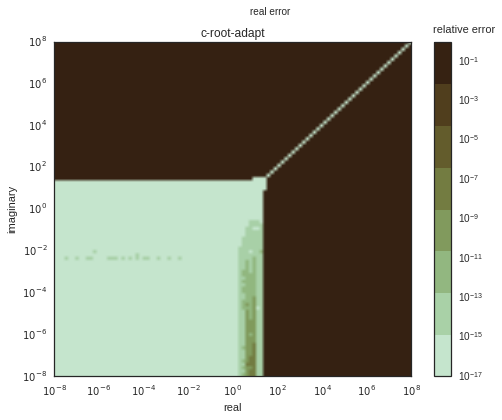

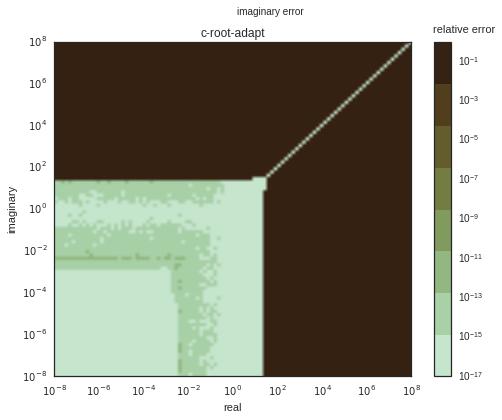

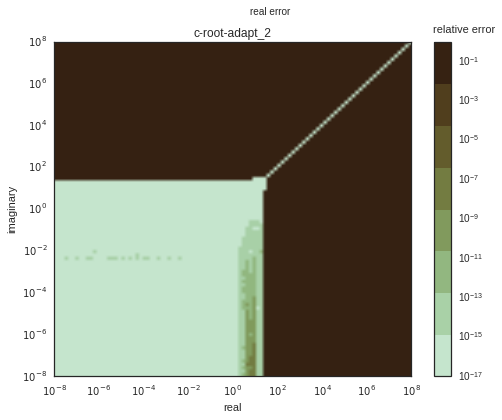

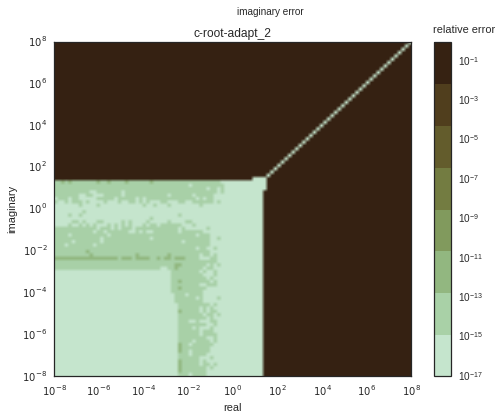

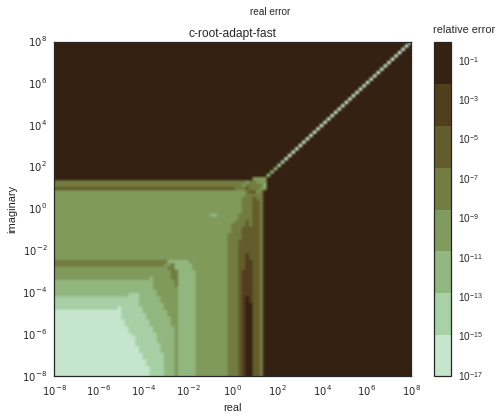

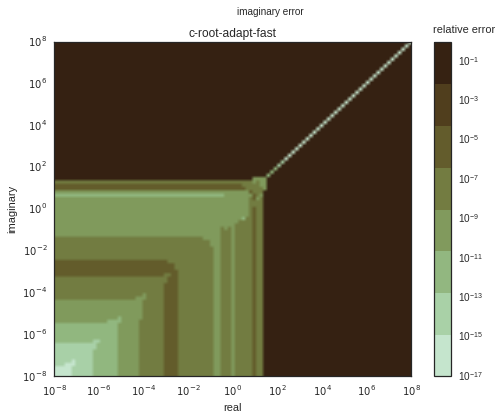

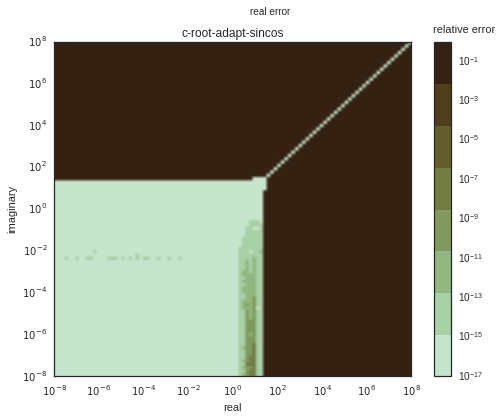

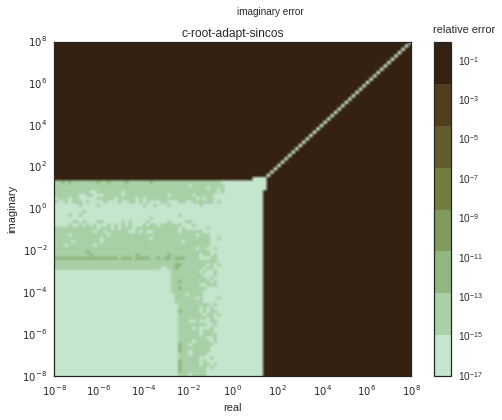

In [53]:
for implementation, function in wofz_impl.iteritems():
    wr, wi = function(x, y)
    real_error = np.abs(wr - wr_ref)/wr_ref
    imag_error = np.abs(wi - wi_ref)/wi_ref
    plot_error(x, y, real_error, title=implementation, unify=True)
    plt.suptitle('real error')
    plot_error(x, y, imag_error, title=implementation, unify=True)
    plt.suptitle('imaginary error')


In [63]:
a, b = np.atleast_2d(800.), np.atleast_2d(900.)

In [64]:
res_cra = wofz_impl['c-root-adapt'](a, b)
res_mp = wofz_impl['mp'](a, b)

In [65]:
"%.20f"%res_cra[0]

'nan'

In [62]:
"%.20f"%res_mp[0]

'0.03510961982181501351'

## III. Timing Benchmark

In [123]:
def plot_timing(x,y,z, title):
    fig, ax = plt.subplots(figsize=(8,6))
    z = np.clip(a=z, a_min=1e-17, a_max=1e0)
    im  = ax.imshow(
                   z.astype(np.float64),
                   origin="bottom",extent=[exp_min,exp_max,exp_min,exp_max],aspect='auto',
    )


    # Plot look: axes, title, ticks, ...
    cbar = plt.colorbar(im)
    cbar.set_label('t [s] per call', labelpad=-18, y=1.05, rotation=0)
    ax.set_title(title)
    ax.set_xlabel('real')
    ax.set_ylabel('imagiary')
    ax.set_xticklabels([ "$10^{" + str(i) + "}$" for i in range(exp_min, exp_max + 1, 2)])
    ax.set_yticklabels([ "$10^{" + str(i) + "}$" for i in range(exp_min, exp_max + 1, 2)])
    
    return fig, ax

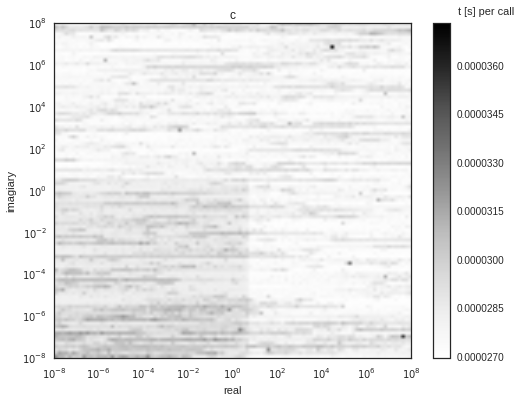

In [124]:
exp_min = -8
exp_max = 8

r = 10**np.linspace(exp_min, exp_max, 101)
x, y = np.meshgrid(r, r)


def dummy(a,b):
    pass

def timeit(x,y, function, nrep_timing=3, n_entries_array=50):
    '''Time the implementation on the arrays x,y = x +iy'''
    T = np.zeros(x.shape)
    timings = np.zeros(nrep_timing)
    for el in xrange(len(x)):
        for el2 in xrange(len(x[0])):
            xx = np.ones(n_entries_array)*x[el][el2]
            yy = np.ones(n_entries_array)*y[el][el2]
            for i in xrange(nrep_timing):
                with Timer() as t:
                    wr, wi = function(xx, yy)
                timings[i] = t.interval_s
            T[el,el2] = np.mean(timings)/n_entries_array
            dummy(wr,wi) # use wr, wi, otherwise they might get optimized away
    return T
if test is True:
    fn = wofz_impl['c']
    z = timeit(x,y, fn)
    plot_timing(x,y,z, 'c')

c
c-root-adapt-fast
py
f90-2
f90-1
scipy
c-root-adapt_2
c-root-adapt
c-root-adapt-sincos
cuda


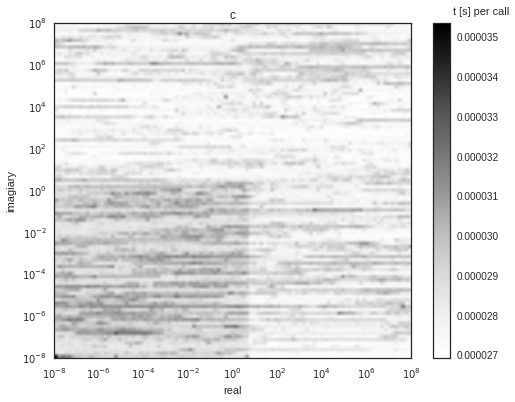

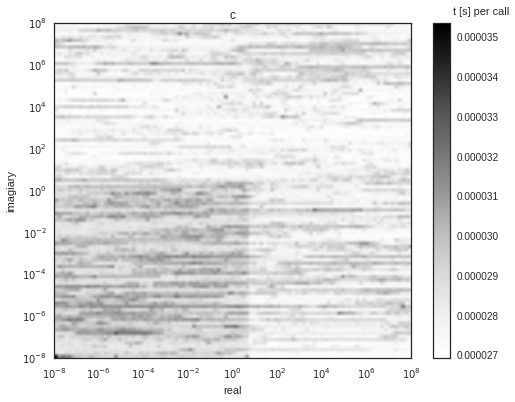

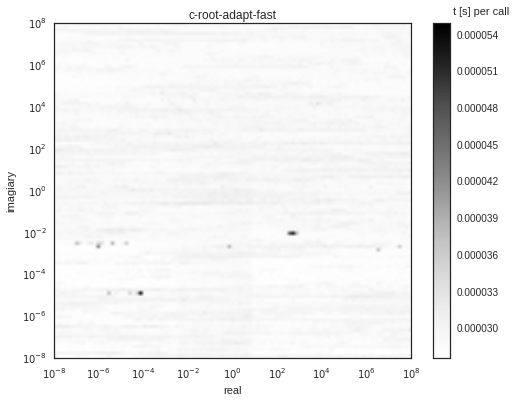

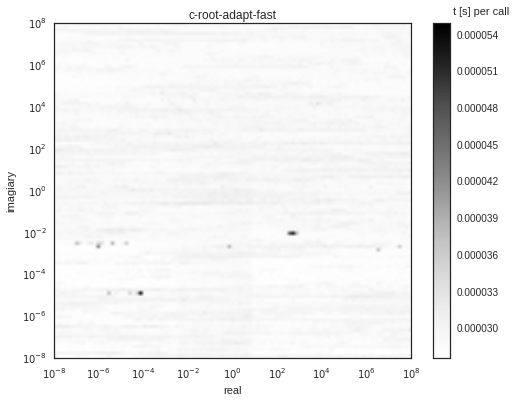

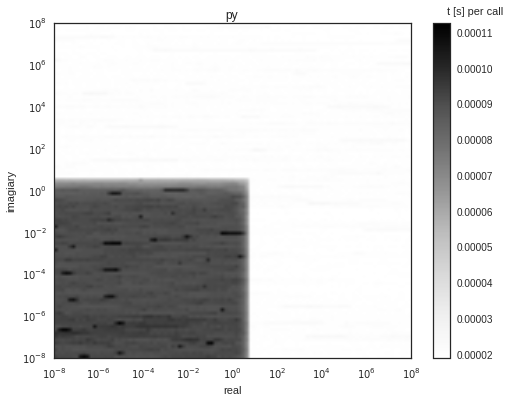

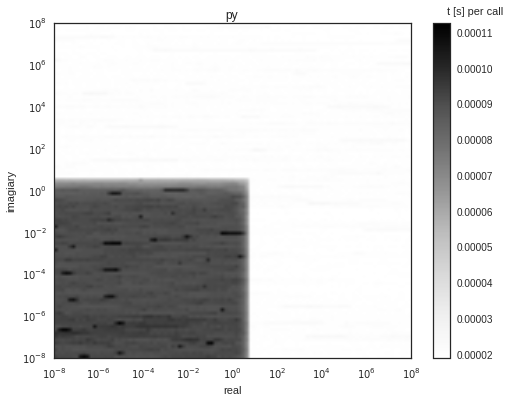

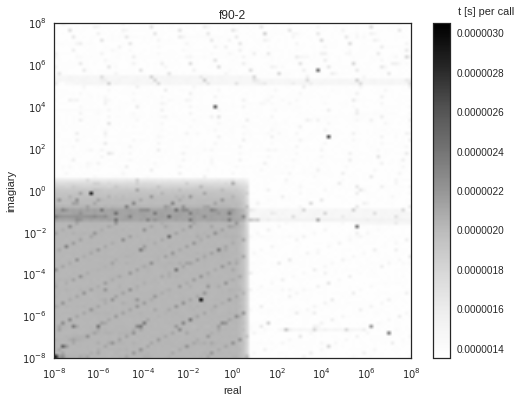

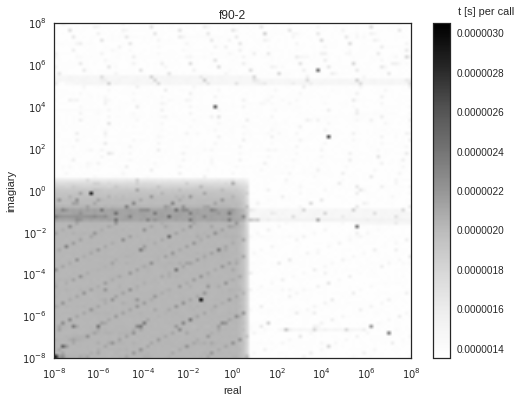

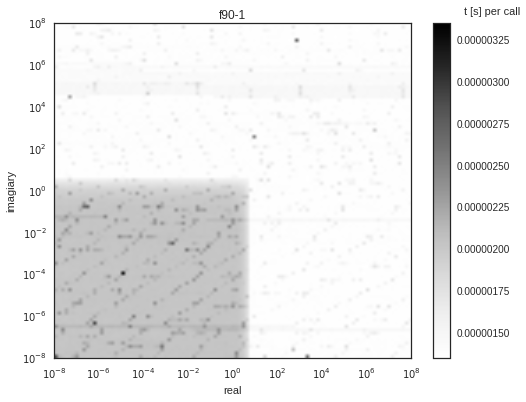

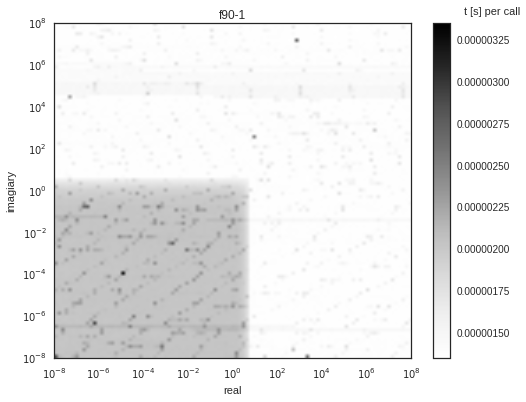

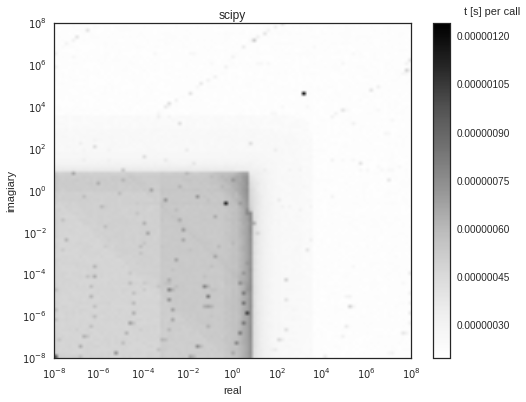

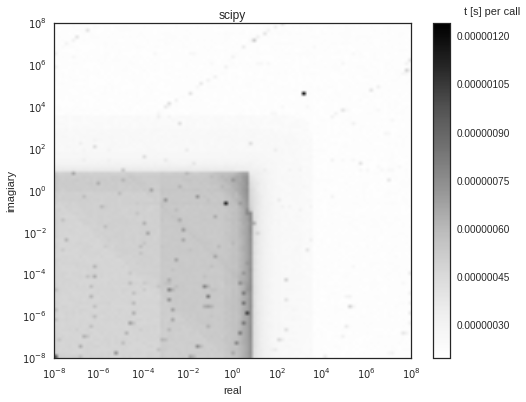

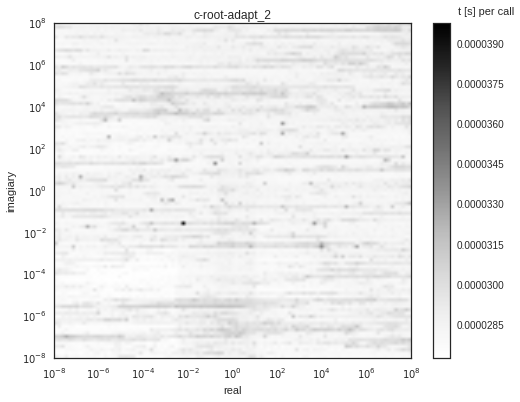

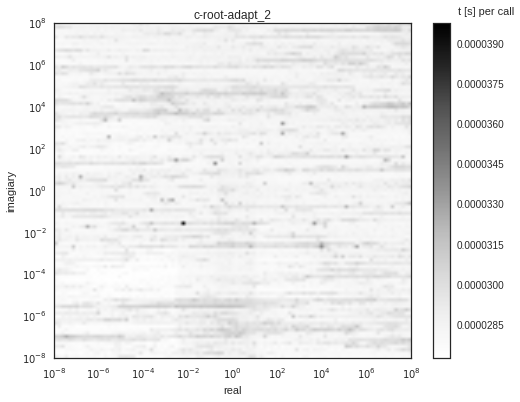

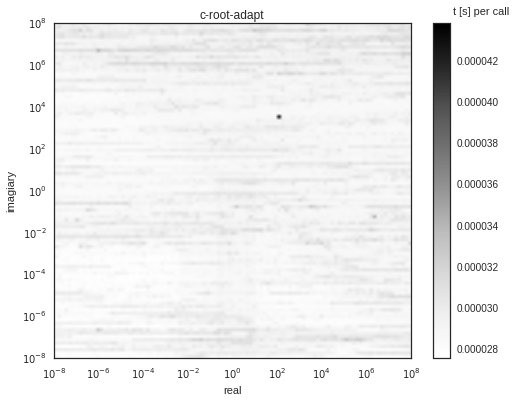

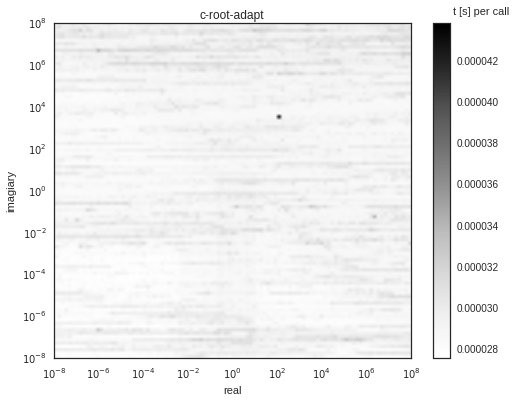

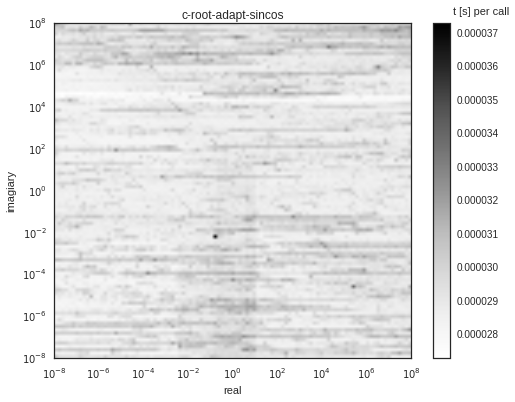

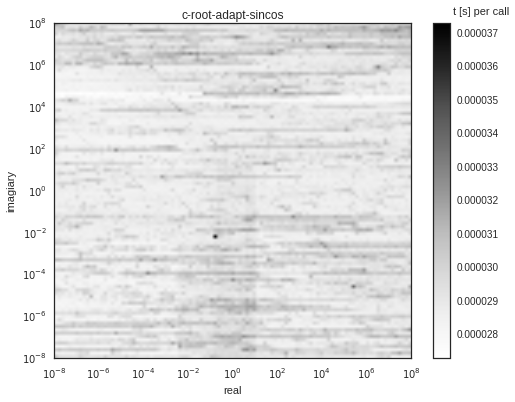

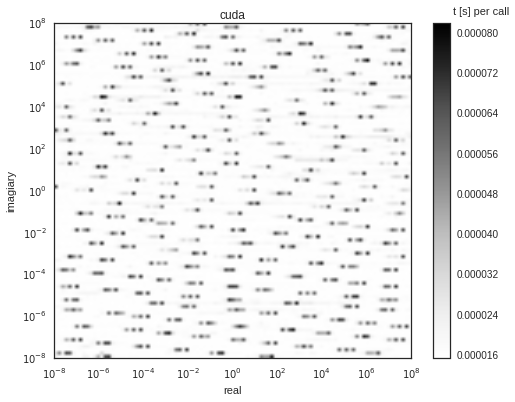

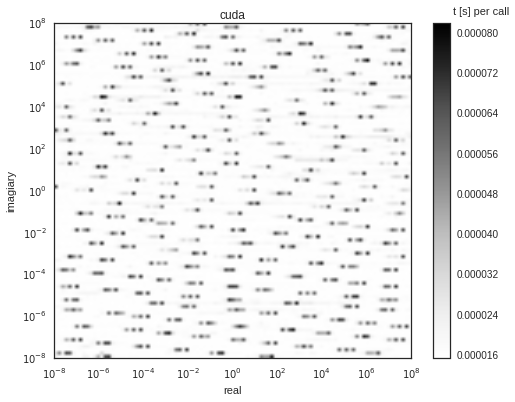

In [125]:
for implementation, function in wofz_impl.iteritems():
    if implementation is not 'mp':
        print(implementation)
        z = timeit(x,y, function)
        plot_timing(x,y,z, title=implementation)
        plot_timing(x,y,z, title=implementation)

# IV. Memory Footprint
Computed by hand, counting the number of variables and lookup tables. Neglecting the memory needed by calls to pow, exp etc. Assuming 4 bytes for integers. Not counting the memory for the input and output. Constants are treated as variables of the corresponding size. Variables: all declarations of variables, even if they might be eliminated by the compiler. Tables: all memory used to store fixed constants, lookup tables, ... . Some values are estimates because they depend on the program flow (if/else branches).
- cernlib-c: 684 Bytes
- f90-1: 692 Bytes
- f90-2: 716 Bytes
- cernlib-cuda: 684 Bytes
- cernlib-root-adapted-FAST_IMPL: Tables: 704 Bytes, Vars: ~350 Bytes
- cenlib-root-adapted: Tables: 2688 Bytes, Vars: ~ 600 Bytes




#  V. Comments

## include C via cython instead of ctypes

Cython allows to call the C function in a less involved way which leads to much less overhead and therefore more realistic C performance. This fact is also partly due to the numpy.ndarray output creation being implemented on the C side and not in python (as it happens in the ctypes case).

Ctypes rely on calling the `Makefile` before running this section.

Defining the cython interface:

In [6]:
%%cython --name cernlib_c_cython
# distutils: sources = ./cernlib_c/ErrorFunctions.c

import numpy as np
cimport numpy as np

cdef extern void cerrf(double in_real, double in_imag, double* out_real, double* out_imag)

cpdef tuple wofz(np.ndarray[double, ndim=2, mode="c"] in_real,
                 np.ndarray[double, ndim=2, mode="c"] in_imag):
    cdef np.ndarray[double, ndim=2, mode="c"] out_real = \
        np.empty_like(in_real)
    cdef np.ndarray[double, ndim=2, mode="c"] out_imag = \
        np.empty_like(in_real)
    cdef int i = 0
    cdef int j = 0
    cdef int m = in_real.shape[0]
    cdef int n = in_real.shape[1]
    for i in xrange(m):
        for j in xrange(n):
            cerrf(in_real[i, j], in_imag[i, j], &out_real[i, j], &out_imag[i, j])
    return (out_real, out_imag)

In [7]:
from cernlib_c_cython import wofz as test_cython

Defining the ctypes interface:

In [10]:
import ctypes
from numpy.ctypeslib import ndpointer
np_double_p = ndpointer(dtype=np.float64)

dll = ctypes.cdll.LoadLibrary('cernlib_c/wofz.so')
dll.cerrf.restype = None
dll.cerrf.argtypes = [ctypes.c_double, ctypes.c_double, np_double_p, np_double_p]

def test_ctypes(x, y):
    in_real = ctypes.c_double(x)
    in_imag = ctypes.c_double(y)
    out_real = np.empty(1, dtype=np.float64)
    out_imag = np.empty(1, dtype=np.float64)
    dll.cerrf(in_real, in_imag, out_real, out_imag)
    return out_real[0], out_imag[0]

test_ctypes = np.vectorize(test_ctypes)

For single values, there is already a huge difference (half of which comes from the numpy allocation and ctypes conversion):

In [48]:
a, b = np.atleast_2d(1.), np.atleast_2d(2.)

In [11]:
print ('ctypes implementation:')
t_ctypes = %timeit -o -c test_ctypes(a, b)
print ('\n\ncython implementation:')
t_cython = %timeit -o -c test_cython(a, b)
print ('\n\nratio between ctypes and cython:\n{0:.2f}'.format(
    t_ctypes.best / t_cython.best))

ctypes implementation:
The slowest run took 8.74 times longer than the fastest. This could mean that an intermediate result is being cached 
10000 loops, best of 3: 111 µs per loop


cython implementation:
100000 loops, best of 3: 4.43 µs per loop


ratio between ctypes and cython:
25.05


For large arrays it becomes even more evident:

In [12]:
exp_min = -8
exp_max = 8

r = 10**np.linspace(exp_min, exp_max, 101)
x, y = np.meshgrid(r, r)

In [14]:
print ('ctypes implementation:')
t_ctypes = %timeit -o -c test_ctypes(x, y)
print ('\n\ncython implementation:')
t_cython = %timeit -o -c test_cython(x, y)
print ('\n\nratio between ctypes and cython:\n{0:.2f}'.format(
       t_ctypes.best / t_cython.best))

ctypes implementation:
1 loops, best of 3: 261 ms per loop


cython implementation:
100 loops, best of 3: 4.14 ms per loop


ratio between ctypes and cython:
63.05


## Impact of C compiler options to cython

By using more aggressive compiler options for `gcc` one can improve the cythonised functions in terms of speed:

In [49]:
%%cython --name cernlib_c_cython_aggr
# distutils: sources = ./cernlib_c/ErrorFunctions.c
# distutils: extra_compile_args = -std=c99 -W -Wall -Wextra -pedantic -O3 -ftree-vectorize

import numpy as np
cimport numpy as np

cdef extern void cerrf(double in_real, double in_imag, double* out_real, double* out_imag)

cpdef tuple wofz(np.ndarray[double, ndim=2, mode="c"] in_real,
                 np.ndarray[double, ndim=2, mode="c"] in_imag):
    cdef np.ndarray[double, ndim=2, mode="c"] out_real = \
        np.empty_like(in_real)
    cdef np.ndarray[double, ndim=2, mode="c"] out_imag = \
        np.empty_like(in_real)
    cdef int i = 0
    cdef int j = 0
    cdef int m = in_real.shape[0]
    cdef int n = in_real.shape[1]
    for i in xrange(m):
        for j in xrange(n):
            cerrf(in_real[i, j], in_imag[i, j], &out_real[i, j], &out_imag[i, j])
    return (out_real, out_imag)

In [50]:
from cernlib_c_cython_aggr import wofz as test_cython_aggr

The corresponding timing as in the previous section shows no influence from the more aggressive compiler options:

In [51]:
print ('default cython implementation:')
t_cython_def = %timeit -o -c test_cython(a, b)
print ('\n\ncompiler flag optimised cython implementation:')
t_cython_aggr = %timeit -o -c test_cython_aggr(a, b)
print ('\n\nratio between default and optimised:\n{0:.2f}'.format(
       t_cython_def.best / t_cython_aggr.best))

default cython implementation:
The slowest run took 9.03 times longer than the fastest. This could mean that an intermediate result is being cached 
100000 loops, best of 3: 4.54 µs per loop


compiler flag optimised cython implementation:
100000 loops, best of 3: 4.55 µs per loop


ratio between default and optimised:
1.00


The results are still the same:

In [58]:
res_def = np.array(test_cython(x, y))
res_aggr = np.array(test_cython_aggr(x, y))
print ('Identical arrays? -->', np.all(res_def == res_aggr))

('Identical arrays? -->', True)


### -ffast-math introduces small errors but improves the speed

In [54]:
%%cython --name cernlib_c_cython_fastmath
# distutils: sources = ./cernlib_c/ErrorFunctions.c
# distutils: extra_compile_args = -ffast-math

import numpy as np
cimport numpy as np

cdef extern void cerrf(double in_real, double in_imag, double* out_real, double* out_imag)

cpdef tuple wofz(np.ndarray[double, ndim=2, mode="c"] in_real,
                 np.ndarray[double, ndim=2, mode="c"] in_imag):
    cdef np.ndarray[double, ndim=2, mode="c"] out_real = \
        np.empty_like(in_real)
    cdef np.ndarray[double, ndim=2, mode="c"] out_imag = \
        np.empty_like(in_real)
    cdef int i = 0
    cdef int j = 0
    cdef int m = in_real.shape[0]
    cdef int n = in_real.shape[1]
    for i in xrange(m):
        for j in xrange(n):
            cerrf(in_real[i, j], in_imag[i, j], &out_real[i, j], &out_imag[i, j])
    return (out_real, out_imag)

In [55]:
from cernlib_c_cython_fastmath import wofz as test_cython_fastmath

The corresponding timing as in the previous section shows a few percents difference for small array lengths:

In [56]:
print ('default cython implementation:')
t_cython_def = %timeit -o -c test_cython(a, b)
print ('\n\nfastmath optimised cython implementation:')
t_cython_fastmath = %timeit -o -c test_cython_fastmath(a, b)
print ('\n\nratio between default and optimised:\n{0:.2f}'.format(
       t_cython_def.best / t_cython_fastmath.best))

default cython implementation:
The slowest run took 13.13 times longer than the fastest. This could mean that an intermediate result is being cached 
100000 loops, best of 3: 4.72 µs per loop


fastmath optimised cython implementation:
100000 loops, best of 3: 4.43 µs per loop


ratio between default and optimised:
1.06


... which is negligible for large arrays:

In [57]:
print ('default cython implementation:')
t_cython_def = %timeit -o -c test_cython(x, y)
print ('\n\nfastmath optimised cython implementation:')
t_cython_fastmath = %timeit -o -c test_cython_fastmath(x, y)
print ('\n\nratio between default and optimised:\n{0:.2f}'.format(
       t_cython_def.best / t_cython_fastmath.best))

default cython implementation:
100 loops, best of 3: 4.14 ms per loop


fastmath optimised cython implementation:
100 loops, best of 3: 4.13 ms per loop


ratio between default and optimised:
1.00


-fast-math introduces small errors though:

In [59]:
res_def = np.array(test_cython(x, y))
res_fastmath = np.array(test_cython_fastmath(x, y))
print ('Identical arrays? -->', np.all(res_def == res_fastmath))

('Identical arrays? -->', False)


In [60]:
np.max(res_def - res_fastmath)

1.3322676295501878e-15